# Dictionary learning

* Some images may be naturally sparse under different linear transforms
* We may not know a good transform, can we build one from a set of training images?

We need to solve

$$\min_{z, D} \sum_{i=1}^m \frac{1}{2}\|Dz - u_i\|_2^2 + \alpha \|z\|_1,$$

under suitable constraints on $D$.

In [23]:
from sklearn.decomposition import DictionaryLearning
from sklearn.datasets import load_digits, make_sparse_coded_signal
import matplotlib.pyplot as plt 
import numpy as np

n_train = 100
n_test = 50

digits = load_digits()
U_train = digits.data[:n_train]
U_test = digits.data[n_train:n_train+n_test]

In [2]:
def show_digits(U,m,n):
    fig, ax = plt.subplots(m,n)
    k = 0
    for i in range(m):
        for j in range(n):
            ax[i,j].imshow(U[k,:].reshape(8,8),cmap='gray')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            k += 1
    fig.tight_layout()

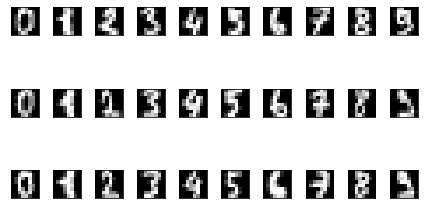

In [3]:
show_digits(U_train[:30],3,10)

In [4]:
# initialise dictionary learner
dict_learner = DictionaryLearning(n_components=15, transform_algorithm='lasso_lars', random_state=42)

# learn dictionary and fit
Z_train = dict_learner.fit_transform(U_train)

In [10]:
# compute sparsity level
print('NNZ:', np.mean(Z_train == 0)/64/n_train)

# compute training error (MSE)
U_hat = Z_train @ dict_learner.components_
print('MSE:', np.mean(np.sum((U_hat - U_train) ** 2, axis=1) / np.sum(U_train ** 2, axis=1)))

NNZ: 5.6770833333333335e-05
MSE: 0.038388440168770396


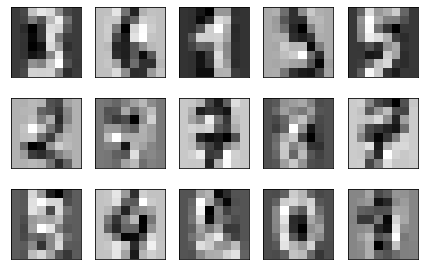

In [11]:
# plot dictionary elements
show_digits(dict_learner.components_,3,5)

In [12]:
# compute testing error
Z_test = dict_learner.transform(U_test)

# compute sparsity level
print('NNZ:', np.mean(Z_test == 0)/64/n_test)

# compute training error (MSE)
U_hat = Z_test @ dict_learner.components_
print('MSE:', np.mean(np.sum((U_hat - U_test) ** 2, axis=1) / np.sum(U_test ** 2, axis=1)))

NNZ: 6.916666666666666e-05
MSE: 0.05904831763475732


See https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

In [25]:
U,D,Z = make_sparse_coded_signal(n_samples = 200, n_components = 20, n_features = 100, n_nonzero_coefs = 5)

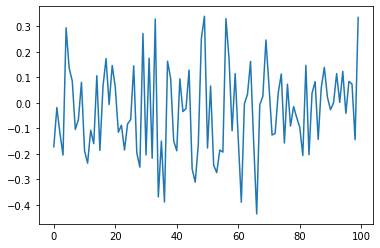

In [27]:
plt.plot(U[:,1])

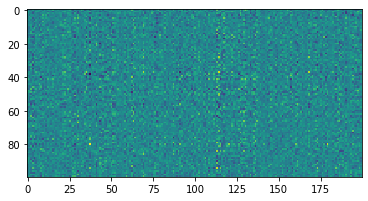

In [34]:
plt.imshow(D@Z)

In [29]:
Z.shape

(20, 200)